In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from scipy.stats import kendalltau, norm
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib import rc
import matplotlib as mpl
import seaborn as sns

plt.style.use('seaborn')
rc('text', usetex=False)
%matplotlib inline

In [3]:
%load_ext autoreload
%aimport utils
%autoreload 1
from utils import *

In [4]:
legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

## Import scores from CSV

In [5]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

## Split data into train and test

In [6]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [7]:
def train_test_split(scores, train_years, test_years):
    ''' Take all scores (for either male and female) 
    and split them into 4 different tables: 
    1. Season scores for training years
    2. World scores for training years
    3. Season scores for testing years
    4. World scores for testing years
    '''
    season_scores = scores.loc[scores['event']!='WR']
    world_scores = scores.loc[scores['event']=='WR']
    
    season_train = season_scores.loc[season_scores['year'].isin(train_years)]
    world_train = world_scores.loc[world_scores['year'].isin(train_years)]
    season_test = season_scores.loc[season_scores['year'].isin(test_years)]
    world_test = world_scores.loc[world_scores['year'].isin(test_years)]    
    
    return season_train, world_train, season_test, world_test

In [8]:
# Create train and test score tables for male skaters
season_train, world_train, season_test, world_test = train_test_split(male_scores, train_years, test_years)
season_train.shape, world_train.shape, season_test.shape, world_test.shape

((1216, 4), (238, 4), (507, 4), (96, 4))

### Visualize season scores by event

Use scores of male skaters in 2017 season for demos

In [9]:
season_scores, world_scores = get_yearly_scores(2017, season_train, world_train)

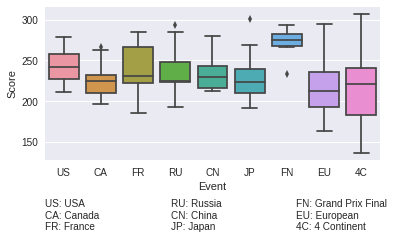

In [10]:
fig = plt.figure()
grid = plt.GridSpec(4, 3, hspace=1.5, wspace=0.5)
ax_box = fig.add_subplot(grid[:-1, :])
ax_box = sns.boxplot(x='event', y='score', data=season_scores, ax=ax_box)
ax_box.set_xlabel('Event')
ax_box.set_ylabel('Score')

ax_label1 = fig.add_subplot(grid[-1, 0])
ax_label2 = fig.add_subplot(grid[-1, 1])
ax_label3 = fig.add_subplot(grid[-1, 2])

for ax in [ax_label1, ax_label2, ax_label3]:
    ax.set_facecolor('white')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
ax_label1.text(0, 1, s='US: USA\nCA: Canada\nFR: France',
               verticalalignment='top',
               transform=ax_label1.transAxes)
ax_label2.text(0, 1, s='RU: Russia\nCN: China\nJP: Japan',
               verticalalignment='top',
               transform=ax_label2.transAxes)
ax_label3.text(0, 1, s='FN: Grand Prix Final\nEU: European\n4C: 4 Continent',
               verticalalignment='top',
               transform=ax_label3.transAxes)
fig.savefig('viz/boxplot_2017_male.png')

## Implement kendall tau metrics

In [11]:
def return_ranking(skater_scores, world_scores):
    '''
    Return predicted ranking and world rankings (as lists)
    from Series of corresponding scores.
    The reason why both rankings are returned at once is because
    not all skaters in the season will participate in the world championship,
    and vice versa. Therefore, only skaters who participated in both
    will be of interest.    
    '''
    skater_scores = skater_scores.sort_values(ascending=False)
    world_scores = world_scores.sort_values(ascending=False)
    skater_ranking = list(skater_scores.index.intersection(world_scores.index))
    world_ranking = list(world_scores.index.intersection(skater_scores.index))
    return skater_ranking, world_ranking

In [12]:
def calculate_kendall_tau(skater_ranking, world_ranking, verbose=True):
    '''
    Caluculate kendall's tau from two ranking lists of the same size
    '''
    # Generate set of ordered pairs from each ranking
    skater_pairs = set(combinations(skater_ranking, 2))
    world_pairs = set(combinations(world_ranking, 2))
    
    # Calculate number of total, concordant & discordant pairs and tau
    n_pairs = len(skater_pairs)
    n_concordant_pairs = len(skater_pairs & world_pairs)
    
    if verbose:
        print(f'There are {n_concordant_pairs} concordant_pairs out of {n_pairs} pairs')
        
    # Calculate Kendall's tau from pair counts
    tau = (2 * n_concordant_pairs - n_pairs) / n_pairs
    return tau 

## Average skate score model

Calculate season average for each skater

In [13]:
season_avg = season_scores.groupby('name')['score'].mean().sort_values(ascending=False)
season_avg.head()
season_avg.to_csv('data/season_avg.csv')

Predict ranking using season average and evaluate its Kendall's tau

In [14]:
avg_ranking, world_ranking = return_ranking(season_avg, world_scores)
avg_kendall_tau = calculate_kendall_tau(avg_ranking, world_ranking)
avg_kendall_tau

There are 234 concordant_pairs out of 276 pairs


0.6956521739130435

Result agrees with kendalltau from scipy

In [15]:
season_numeric_rank = list(range(len(avg_ranking)))
world_numeric_rank = [avg_ranking.index(skater) for skater in world_ranking]
kendalltau(season_numeric_rank, world_numeric_rank)

KendalltauResult(correlation=0.6956521739130435, pvalue=1.9126097800691154e-06)

RMSE with mean model

In [16]:
score_comparison = pd.merge(season_scores, season_avg.to_frame(), left_on='name', right_index=True, suffixes=['', '_avg'])
score_comparison['sq_error'] = (score_comparison['score'] - score_comparison['score_avg'])**2
np.sqrt(score_comparison['sq_error'].mean())

10.271546837961868

### Visualize Kendall's tau

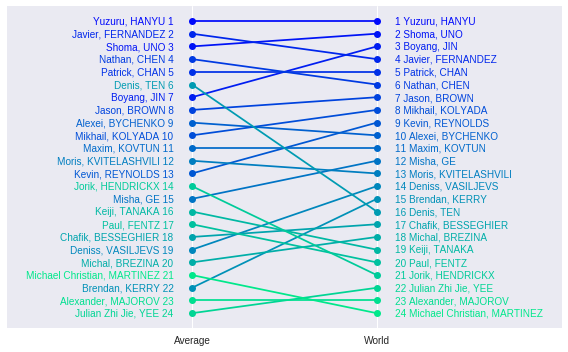

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_rankings(fig, ax, [avg_ranking, world_ranking], ['Average', 'World'], 'viz/rank_avg_world.png')

## Linear (Additive) model

Create dummies binary dataframe while dropping one skater and one event

In [18]:
dummies = pd.get_dummies(season_scores[['name', 'event']], prefix=['', ''], prefix_sep='', drop_first=True)
unique_skaters = season_scores['name'].unique()
unique_events = season_scores['event'].unique()

dummies_skater_count = len(unique_skaters) - 1
dummies_skaters = dummies.columns[:dummies_skater_count]
dummies_events = dummies.columns[dummies_skater_count:]

dropped_skater = list(set(unique_skaters) - set(dummies_skaters))[0]
dropped_event = list(set(unique_events) - set(dummies_events))[0]

### Apply normal equation

In [19]:
# Create numpy feature matrix and response vector
X = dummies.values
y = season_scores['score'].values

# Append column of all 1's to the left of feature matrix
X = np.insert(X, obj=0, values=1, axis=1)

# Apply normal equation to find linear regression coefficients (including intercept)
coefs_linear = np.linalg.inv(X.T @ X) @ (X.T @ y)
coefs_linear[:10]

array([ 262.83064921,  -58.77196129,  -27.74060019,  -38.56497213,
        -16.6525816 , -100.78064921,  -36.58476179,    3.9048582 ,
        -45.88750626,  -35.41149857])

In [20]:
linear_rmse = np.sqrt(np.mean((y - X @ coefs_linear)**2))
linear_rmse

8.838699611397724

Double check with sklearn's LinearRegression and mean_square_error

In [21]:
lin = LinearRegression(fit_intercept=False)
lin.fit(X, y)
lin.coef_[:10], lin.intercept_

(array([ 262.83064921,  -58.77196129,  -27.74060019,  -38.56497213,
         -16.6525816 , -100.78064921,  -36.58476179,    3.9048582 ,
         -45.88750626,  -35.41149857]), 0.0)

In [22]:
np.sqrt(mean_squared_error(y, X @ lin.coef_))

8.838699611397724

Add back dropped baseline skater and event

In [23]:
# Extract baseline, skater, and event scores from regression coefficients
baseline_score = coefs_linear[0]
skater_scores = pd.Series(coefs_linear[1:dummies_skater_count+1], index=dummies_skaters)
event_scores = pd.Series(coefs_linear[dummies_skater_count+1:], index=dummies_events)

# Add back scores of dropped skater and dropped event
skater_scores[dropped_skater] = 0
event_scores[dropped_event] = 0

# Sort skater scores and event scores from highest to lowest
skater_scores.sort_values(ascending=False, inplace=True)
event_scores.sort_values(ascending=False, inplace=True)

Latent scores obtained from model

In [24]:
baseline_score

262.83064920747165

In [25]:
event_scores

EU     6.604323
4C     0.000000
CN    -4.467169
RU    -4.601699
US    -4.609353
FR    -7.670076
CA   -12.882929
FN   -14.152519
JP   -15.906827
dtype: float64

In [26]:
skater_scores

Yuzuru, HANYU                   38.439919
Javier, FERNANDEZ               27.616843
Nathan, CHEN                    27.606706
Shoma, UNO                      26.752743
Patrick, CHAN                   15.395005
Denis, TEN                      14.099427
Boyang, JIN                      3.904858
Adam, RIPPON                     0.000000
Jason, BROWN                   -11.758589
Sergei, VORONOV                -13.772388
Alexei, BYCHENKO               -16.652582
Takahito, MURA                 -17.279147
Mikhail, KOLYADA               -17.805915
Max, AARON                     -19.136215
Maxim, KOVTUN                  -22.346583
Kevin, REYNOLDS                -22.704185
Misha, GE                      -24.466314
Keiji, TANAKA                  -24.817807
Nam, NGUYEN                    -26.401923
Alexander, PETROV              -27.740600
Jorik, HENDRICKX               -28.292281
Moris, KVITELASHVILI           -31.234972
Timothy, DOLENSKY              -31.691296
Han, YAN                       -32

Create predicted ranking from model and evaluate its Kendall's tau

In [27]:
linear_ranking, world_ranking = return_ranking(skater_scores, world_scores)

In [28]:
calculate_kendall_tau(linear_ranking, world_ranking)

There are 239 concordant_pairs out of 276 pairs


0.7318840579710145

In [29]:
np.save('data/add_ranking_2017', linear_ranking)

### Visualisations

Save predicted rankings to format later in Google Sheets

In [30]:
skater_scores.loc[linear_ranking].to_csv('viz/skater_scores_additive_2017.csv')

Plot chart of predicted scores for all season scores

In [31]:
# Create mega table with all relevant information
df_compare_add = pd.merge(season_scores, event_scores.to_frame(name='event_score'), how='left', left_on='event', right_index=True)
df_compare_add = pd.merge(df_compare_add, skater_scores.to_frame(name='skater_score'), how='left', left_on='name', right_index=True)
df_compare_add = pd.merge(df_compare_add, season_avg.to_frame(name='avg'), left_on='name', how='left', right_index=True)
df_compare_add['baseline'] = baseline_score
df_compare_add['baseline_event'] = df_compare_add['baseline'] + df_compare_add['event_score']
df_compare_add['predicted'] = df_compare_add['baseline'] + df_compare_add['event_score'] + df_compare_add['skater_score']
df_compare_add['residual'] = df_compare_add['predicted'] - df_compare_add['score']
df_compare_add.head()
df_compare_add.to_csv('data/df_compare_add.csv')

In [32]:
def plot_scores(df_compare, filename=None,
                labels=['Baseline', 'Baseline + Event', 'Baseline + Event + Skater (predicted)']):
    # Function to plot predicted score against true score for any model (with appropriate mega-table)
    fig, ax = plt.subplots(figsize=(15, 5))
    x_coords = np.arange(len(df_compare))
    
    ax.scatter(x_coords, df_compare['baseline'], color='tab:green', marker='_', label=labels[0], zorder=0)
    ax.scatter(x_coords, df_compare['baseline_event'], color='tab:blue', marker='_', label=labels[1], zorder=1)
    # For some reason the gray bars don't align correctly, hence the +0.06 correction
    ax.bar(x_coords+0.06, df_compare['score']-df_compare['predicted'], bottom=df_compare['predicted'],
           align='center', color='black', alpha=0.1, zorder=2) 
    ax.scatter(x_coords, df_compare['predicted'], color='tab:orange', marker='_', label=labels[2], zorder=3)
    ax.scatter(x_coords, df_compare['score'], color='tab:red', marker='_', label='True',zorder=4)
    
    # Hide vertical grids
    ax.grid(axis='x')
    
    # Plot grids that separate events instead
    events = df_compare['event'].drop_duplicates()
    event_counts = df_compare['event'].value_counts().loc[events]
    for count in event_counts.cumsum():
        ax.axvline(count-0.5, color='white', zorder=0)
    ax.set_xticks(event_counts.cumsum() - event_counts/2 - 0.5)
    ax.set_xticklabels(events)

    ax.set_xlim([-0.5, len(x_coords)-0.5])
    ax.set_ylim([100, 350])
    ax.set_xlabel('Event', fontsize=15)
    ax.set_ylabel('Season score', fontsize=15)

    ax.legend(loc='lower left', **legend_opts)
    plt.tight_layout()
    plt.show()
    
    if filename:
        fig.savefig(filename)

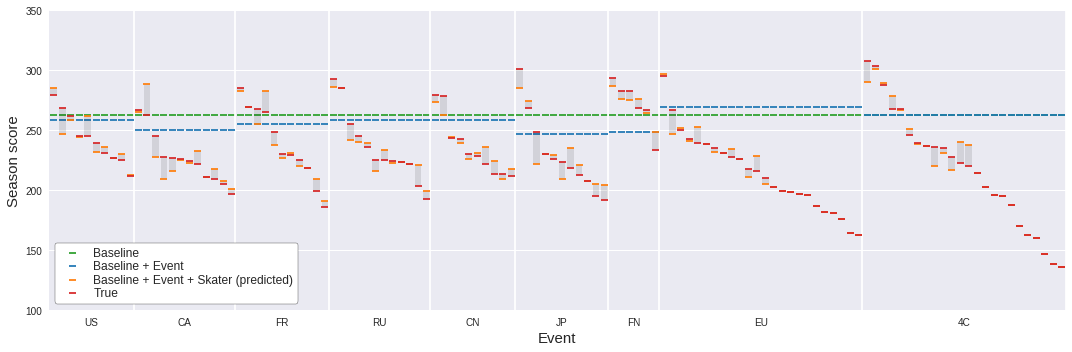

In [33]:
plot_scores(df_compare_add, 'viz/score_add_avg.png')

Plot residual vs fitted, residual histogram and QQ plot for additive model

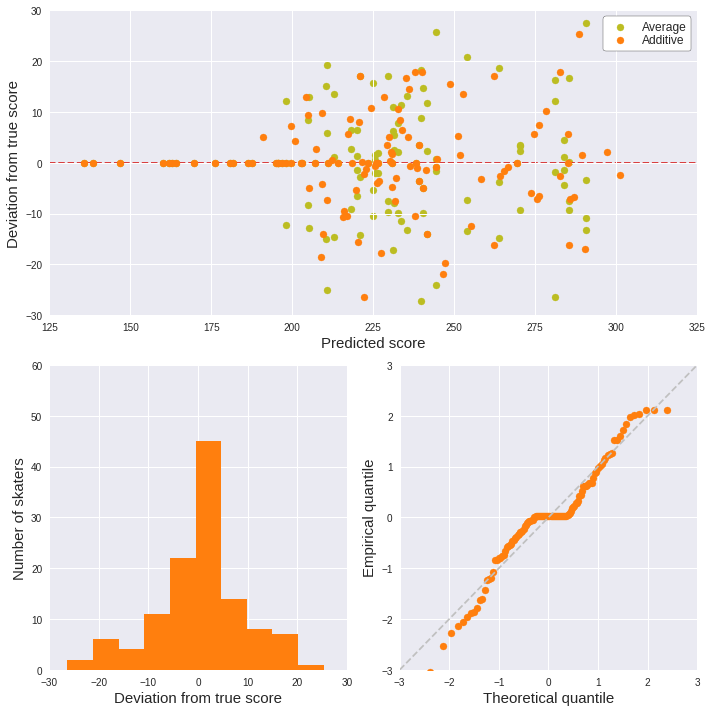

In [34]:
fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(2, 2)

# Plot residual vs fitted
ax = fig.add_subplot(grid[0, :])
ax.scatter(df_compare_add['avg'], df_compare_add['avg']-df_compare_add['score'], color='tab:olive', label='Average', zorder=0)
ax.scatter(df_compare_add['predicted'], df_compare_add['predicted']-df_compare_add['score'], color='tab:orange', label='Additive', zorder=1)
ax.axhline(0, color='tab:red', zorder=0, ls='--')

ax.set_xlabel('Predicted score', fontsize=15)
ax.set_ylabel('Deviation from true score', fontsize=15)
ax.set_xlim([125, 325])
ax.set_ylim([-30, 30])
ax.legend(loc='upper right', **legend_opts)

# Plot residual histogram
ax1 = fig.add_subplot(grid[1, 0])
residuals = (df_compare_add['predicted'] - df_compare_add['score']).values
ax1.hist(residuals, color='tab:orange')

ax1.set_xlim(-30, 30)
ax1.set_xlabel('Deviation from true score', fontsize=15)
ax1.set_ylim(0, 60)
ax1.set_ylabel('Number of skaters', fontsize=15)

# Plot residual QQ plot
ax2 = fig.add_subplot(grid[1, 1])
cum_probs = np.arange(1, len(residuals)) / len(residuals) 
percentiles = norm().ppf(cum_probs)
sorted_residuals = np.sort(residuals)[:-1]
normalized_residual = (sorted_residuals - sorted_residuals.mean()) / sorted_residuals.std()

ax2.scatter(percentiles, normalized_residual, color='tab:orange')
ax2.plot([-3, 3], [-3, 3], '--', color='silver')

ax2.set_xlabel('Theoretical quantile', fontsize=15)
ax2.set_ylabel('Empirical quantile', fontsize=15)
ax2.set_xlim([-3, 3])
ax2.set_ylim([-3, 3])

plt.tight_layout()

fig.savefig('viz/residual_add.png')

Check skaters with zero residuals

In [35]:
skaters_with_small_residual = set(df_compare_add.loc[(df_compare_add['predicted'] - df_compare_add['score']).abs() < 0.001, 'name'])
event_counts_per_skater = df_compare_add['name'].value_counts()
skaters_with_one_event = set(event_counts_per_skater[event_counts_per_skater == 1].index)

All skaters with zero residuals only have one event in the season, and vice versa

In [36]:
skaters_with_small_residual - skaters_with_one_event, skaters_with_one_event - skaters_with_small_residual

(set(), set())

 ### Plot comparison with world ranking

Compare additive ranking with average and world ranking (highlight interesing cases)

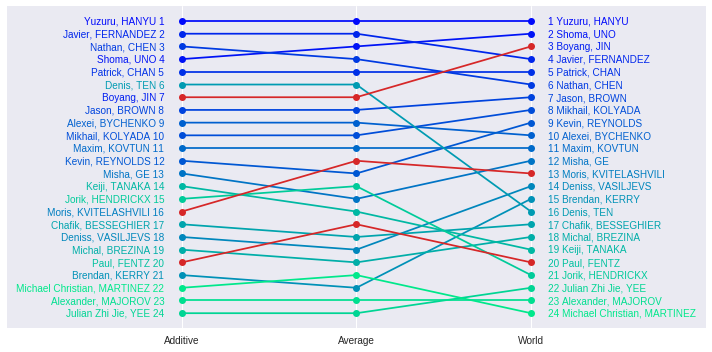

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_multiple_rankings(fig, ax, [linear_ranking, avg_ranking, world_ranking], 
                       ['Additive', 'Average', 'World'])
for line_id in [19, 12, 2]:
    del ax.lines[line_id]
ax.plot(range(3), [4, 7, 4], 'o-', color='tab:red')
ax.plot(range(3), [8, 12, 11], 'o-', color='tab:red')
ax.plot(range(3), [17, 17, 21], 'o-', color='tab:red')
fig.savefig('viz/rank_add_avg_world.png')

## Log-linear (multiplicative) model

Same solution for normal equation as additive model but use np.log(y) instead of y

In [38]:
coefs_loglinear = np.linalg.inv(X.T @ X) @ (X.T @ np.log(y))
coefs_loglinear[:10]

array([ 5.57079276, -0.2537603 , -0.11337176, -0.15854428, -0.06450661,
       -0.48288783, -0.14988655,  0.01455732, -0.19499875, -0.14436472])

Evalute RMSE

In [39]:
loglinear_rmse = np.sqrt(np.mean((y - np.exp(X @ coefs_loglinear))**2))
loglinear_rmse

8.881273109759167

Get back the latent scores from regression coefficients (similar to additive model).

However, take their exponentials at the end to get back the true latent scores.

In [40]:
baseline_score = coefs_loglinear[0]
skater_scores = pd.Series(coefs_loglinear[1:dummies_skater_count+1], index=dummies_skaters)
event_scores = pd.Series(coefs_loglinear[dummies_skater_count+1:], index=dummies_events)

skater_scores[dropped_skater] = 0
event_scores[dropped_event] = 0

skater_scores.sort_values(ascending=False, inplace=True)
event_scores.sort_values(ascending=False, inplace=True)

baseline_score = np.exp(baseline_score)
skater_scores = np.exp(skater_scores)
event_scores = np.exp(event_scores)

Latent scores from model

In [41]:
baseline_score

262.64223001202095

In [42]:
event_scores

EU    1.030049
4C    1.000000
US    0.982756
CN    0.981814
RU    0.979176
FR    0.967969
CA    0.949490
FN    0.945952
JP    0.933197
dtype: float64

In [43]:
skater_scores

Yuzuru, HANYU                  1.154228
Nathan, CHEN                   1.110905
Javier, FERNANDEZ              1.108103
Shoma, UNO                     1.105957
Patrick, CHAN                  1.062009
Denis, TEN                     1.059121
Boyang, JIN                    1.014664
Adam, RIPPON                   1.000000
Jason, BROWN                   0.953747
Sergei, VORONOV                0.947786
Alexei, BYCHENKO               0.937530
Mikhail, KOLYADA               0.933023
Takahito, MURA                 0.932946
Max, AARON                     0.928603
Kevin, REYNOLDS                0.912023
Maxim, KOVTUN                  0.911407
Misha, GE                      0.906351
Keiji, TANAKA                  0.905789
Nam, NGUYEN                    0.898441
Alexander, PETROV              0.892819
Jorik, HENDRICKX               0.891376
Moris, KVITELASHVILI           0.880480
Timothy, DOLENSKY              0.877638
Han, YAN                       0.875485
Gordei, GORSHKOV               0.869104


Double check with sklearn's LinearRegression

In [44]:
lin = LinearRegression(fit_intercept=False)
lin.fit(X, np.log(y))
lin.coef_[:10], lin.intercept_

(array([ 5.57079276, -0.2537603 , -0.11337176, -0.15854428, -0.06450661,
        -0.48288783, -0.14988655,  0.01455732, -0.19499875, -0.14436472]), 0.0)

Evaluate Kendall's tau of multiplicative model

In [45]:
loglinear_ranking, world_ranking = return_ranking(skater_scores, world_scores)

In [46]:
calculate_kendall_tau(linear_ranking, world_ranking)

There are 239 concordant_pairs out of 276 pairs


0.7318840579710145

In [47]:
np.save('data/mul_ranking_2017', loglinear_ranking)

### Visualisations

Save predicted rankings to format later in Google Sheets

In [48]:
skater_scores.loc[loglinear_ranking].to_csv('viz/multiplicative_skater_scores.csv')

Plot comparison between predicted and true scores of the season (not used in Medium post) 

In [49]:
df_compare_mul = pd.merge(season_scores, event_scores.to_frame(name='event_score'), how='left', left_on='event', right_index=True)
df_compare_mul = pd.merge(df_compare_mul, skater_scores.to_frame(name='skater_score'), how='left', left_on='name', right_index=True)
df_compare_mul = pd.merge(df_compare_mul, season_avg.to_frame(name='avg'), left_on='name', how='left', right_index=True)
df_compare_mul['baseline'] = baseline_score
df_compare_mul['baseline_event'] = df_compare_mul['baseline'] * df_compare_mul['event_score']
df_compare_mul['predicted'] = df_compare_mul['baseline'] * df_compare_mul['event_score'] * df_compare_mul['skater_score']
df_compare_mul['residual'] = df_compare_mul['predicted'] - df_compare_mul['score']
df_compare_mul.to_csv('data/df_compare_mul.csv')

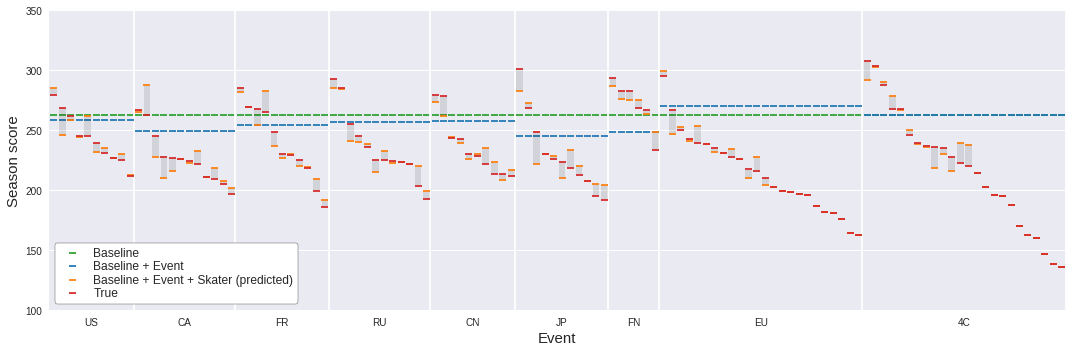

In [50]:
plot_scores(df_compare_mul)

Plot comparison of residuals between all 3 models

In [51]:
avg_residual = (df_compare_mul['avg']-df_compare_mul['score']).values
add_residual = df_compare_add['residual'].values
mul_residual = df_compare_mul['residual'].values

In [52]:
# Calculate height of decorative vertical white bar for each season score
heights = []
for residual_triple in zip(avg_residual, add_residual, mul_residual):
    max_residual, min_residual = max(residual_triple), min(residual_triple)
    if abs(max_residual) > abs(min_residual):
        height = max_residual
    else:
        height = min_residual
    heights.append(height)

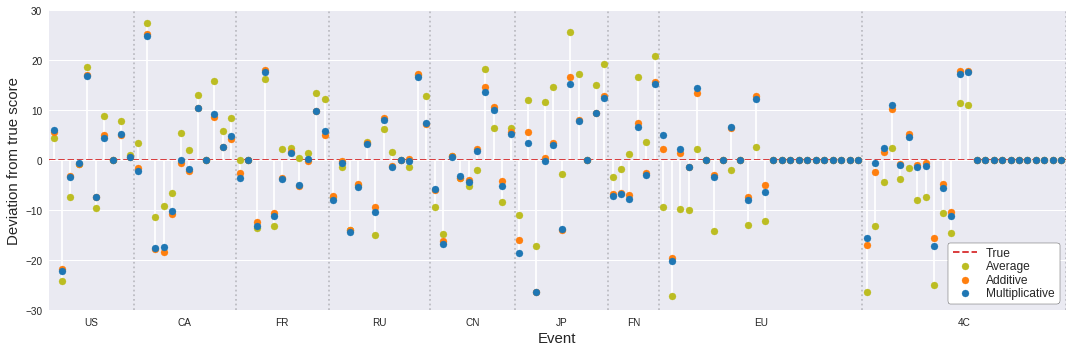

In [53]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot dotted red line at zero
ax.axhline(0, color='tab:red', zorder=0, ls='--', label='True')

# Plot dots for residuals
x_coords = np.arange(len(df_compare_mul))
ax.scatter(x_coords, df_compare_mul['avg']-df_compare_mul['score'], color='tab:olive', label='Average', zorder=1)
ax.scatter(x_coords, df_compare_add['predicted']-df_compare_add['score'], color='tab:orange', label='Additive', zorder=2)
ax.scatter(x_coords, df_compare_mul['predicted']-df_compare_mul['score'], color='tab:blue', label='Multiplicative', zorder=3)

# Plot decorative white bars for each event
ax.vlines(x=x_coords, ymin=[0]*len(heights), ymax=heights, color='white', zorder=0)

# Hide vertical grid
ax.grid(axis='x')

# Plot gridlines between events instead
events = df_compare_mul['event'].drop_duplicates()
event_counts = df_compare_mul['event'].value_counts().loc[events]
for count in event_counts.cumsum():
    ax.axvline(count-0.5, color='black', alpha=0.2, ls='dotted', zorder=0)
ax.set_xticks(event_counts.cumsum() - event_counts/2 - 0.5)
ax.set_xticklabels(events)

ax.legend(loc='lower right', **legend_opts)

ax.set_xlim([-0.5, len(x_coords)-0.5])
ax.set_xlabel('Event', fontsize=15)
ax.set_ylim([-30, 30])
ax.set_ylabel('Deviation from true score', fontsize=15)

plt.tight_layout()
plt.show()

fig.savefig('viz/resid_avg_add_mul.png')

Compare multiplicative ranking with additive and world ranking (highlight interesing cases)

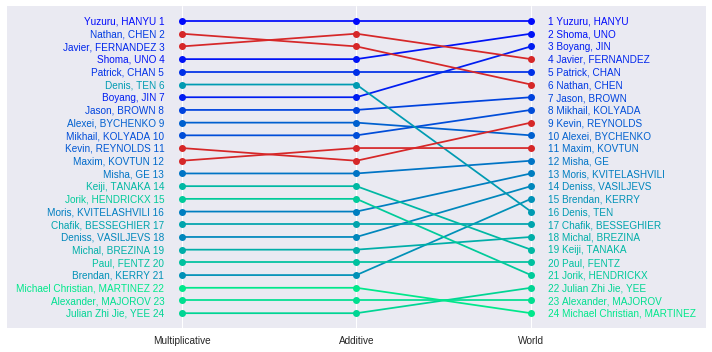

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_multiple_rankings(fig, ax, [loglinear_ranking, linear_ranking, world_ranking],
              ['Multiplicative', 'Additive', 'World'])
for line_id in [10, 8, 5, 3]:
    del ax.lines[line_id]
ax.plot(range(3), [12, 13, 13], 'o-', color='tab:red')
ax.plot(range(3), [13, 12, 15], 'o-', color='tab:red')
ax.plot(range(3), [21, 22, 20], 'o-', color='tab:red')
ax.plot(range(3), [22, 21, 18], 'o-', color='tab:red')
fig.savefig('viz/rank_mul_add_world.png')

## Model penalization

At this point I started to encapsulate the models into separate classes for convenience.

Please refer to classes AverageScore, Linear, and Log in the model.py module for the season average, additive, and multiplicative models respectively. 

### Penalize additive model for 2017 season

Apply penalization to additive model for male skaters in 2017 season

In [55]:
lambda_values = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

Get relevant information for each value of lambda

In [56]:
df_skater_lambda = pd.DataFrame()
df_event_lambda = pd.DataFrame()

df_baseline_lambda = []
rankings_lambda = []
concords_lambda = []
taus_lambda = []
rmses_lambda = []

for lambda_param in lambda_values:
    # Use refactored Linear model class for convenience
    linear = Linear(lambda_param=lambda_param)
    
    # Fit model to 2017 season scores
    linear.fit(season_scores)
    
    # Get latent scores from model
    df_baseline_lambda.append(linear.baseline)
    df_skater_lambda[str(lambda_param)] = linear.skater_scores
    df_event_lambda[str(lambda_param)] = linear.event_scores
    
    # Get predicted rankings, RMSE, number of concordant pairs, and Kendall's tau from model
    rankings_lambda.append(linear.return_ranking(world_scores)[0])
    rmses_lambda.append(round(linear.evaluate_rmse(season_scores), 1))
    concords_lambda.append(linear.evaluate_kendall_tau(world_scores, verbose=False)[1])
    taus_lambda.append(linear.evaluate_kendall_tau(world_scores, verbose=False)[0])
    
df_skater_lambda = df_skater_lambda.loc[world_scores.index]
df_event_lambda = df_event_lambda.loc[dummies_events]

Visualize how skater latent scores get shrinked when lambda increases

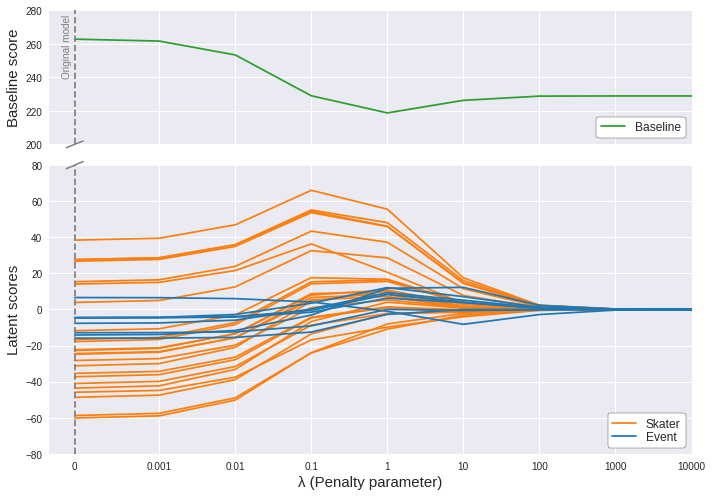

In [57]:
fig = plt.figure(figsize=(10, 7))
grid = plt.GridSpec(3, 1)
ax = fig.add_subplot(grid[1:, :])
axb = fig.add_subplot(grid[0, :])

# Plot baseline score against lambda (using symlog scaling)
axb.plot(lambda_values, df_baseline_lambda, color='tab:green', label='Baseline')
axb.axvline(0, ls='--', color='tab:gray')
axb.text(-0.00015, 278, s='Original model', verticalalignment='top', rotation=90, fontsize=10, color='tab:gray')
axb.plot((-0.0001, 0.0001), (198, 202), color='tab:gray', lw=1.5, transform=axb.transData, clip_on=False)

axb.set_xscale('symlog', linthreshx=0.001)
axb.set_xlim(-0.0003, 10000)
axb.get_xaxis().set_ticklabels([])
axb.set_ylim(200, 280)
axb.set_yticks(np.arange(200, 281, 20))
axb.set_ylabel('Baseline score', fontsize=15)
axb.legend(loc='lower right', **legend_opts)

# Plot latent skater and event scores against lambda (using symlog scaling)
for i, row in df_skater_lambda.iterrows():
    if i == 'Yuzuru, HANYU':
        ax.plot(lambda_values, row.values, color='tab:orange', label='Skater') # Choose one skater for 'Skater' legend
    else:
        ax.plot(lambda_values, row.values, color='tab:orange')
        
        
for i, row in df_event_lambda.iterrows():
    if i == 'CA':
        ax.plot(lambda_values, row.values, color='tab:blue', label='Event') # Choose one event for 'Event' legend
    else:
        ax.plot(lambda_values, row.values, color='tab:blue')        

ax.axvline(0, ls='--', color='tab:gray')
ax.plot((-0.0001, 0.0001), (78, 82), color='tab:gray', lw=1.5, transform=ax.transData, clip_on=False)
ax.legend(loc='lower right', **legend_opts)

ax.set_xscale('symlog', linthreshx=0.001)
ax.set_xlim(-0.0003, 10000)
ax.set_xlabel('λ (Penalty parameter)', fontsize=15)
ax.set_xticklabels(lambda_values)
ax.set_ylabel('Latent scores', fontsize=15)
ax.set_ylim(-80, 80)

plt.tight_layout()
plt.show()

fig.savefig('viz/coeffs_add_lambda.png')

Visualize how lambda affects RMSE, Kendall's tau, and predicted ranking of additive model

In [90]:
rankings_lambda

[['Yuzuru, HANYU',
  'Javier, FERNANDEZ',
  'Nathan, CHEN',
  'Shoma, UNO',
  'Patrick, CHAN',
  'Denis, TEN',
  'Boyang, JIN',
  'Jason, BROWN',
  'Alexei, BYCHENKO',
  'Mikhail, KOLYADA',
  'Maxim, KOVTUN',
  'Kevin, REYNOLDS',
  'Misha, GE',
  'Keiji, TANAKA',
  'Jorik, HENDRICKX',
  'Moris, KVITELASHVILI',
  'Chafik, BESSEGHIER',
  'Deniss, VASILJEVS',
  'Michal, BREZINA',
  'Paul, FENTZ',
  'Brendan, KERRY',
  'Michael Christian, MARTINEZ',
  'Alexander, MAJOROV',
  'Julian Zhi Jie, YEE'],
 ['Yuzuru, HANYU',
  'Javier, FERNANDEZ',
  'Nathan, CHEN',
  'Shoma, UNO',
  'Patrick, CHAN',
  'Denis, TEN',
  'Boyang, JIN',
  'Jason, BROWN',
  'Alexei, BYCHENKO',
  'Mikhail, KOLYADA',
  'Maxim, KOVTUN',
  'Kevin, REYNOLDS',
  'Misha, GE',
  'Keiji, TANAKA',
  'Jorik, HENDRICKX',
  'Moris, KVITELASHVILI',
  'Chafik, BESSEGHIER',
  'Deniss, VASILJEVS',
  'Michal, BREZINA',
  'Paul, FENTZ',
  'Brendan, KERRY',
  'Michael Christian, MARTINEZ',
  'Alexander, MAJOROV',
  'Julian Zhi Jie, YEE'],


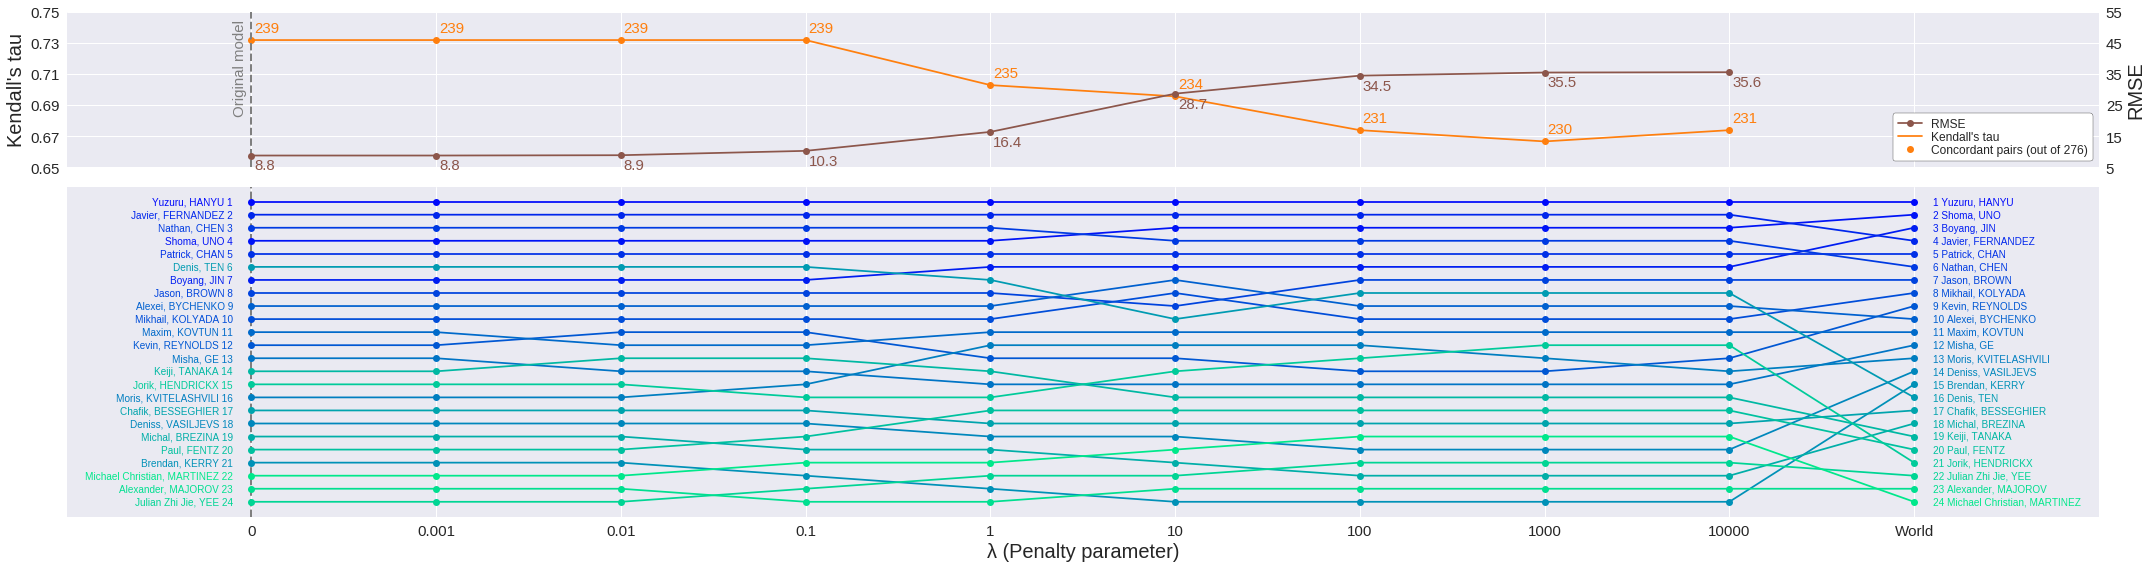

In [58]:
fig = plt.figure(figsize=(30, 8))
grid = plt.GridSpec(3, 1)
ax2 = fig.add_subplot(grid[1:, :])
ax1 = fig.add_subplot(grid[0, :], sharex=ax2)

# Plot concordant pairs and Kendall's tau against lambda
l1 = ax1.plot(taus_lambda, 'o', color='tab:orange', label='Concordant pairs (out of 276)')
l2 = ax1.plot(taus_lambda, color='tab:orange', zorder=10, label="Kendall's tau")
ax1.axvline(0, ls='--', lw=2, color='tab:gray')
ax1.text(-0.10, 0.745, s='Original model', verticalalignment='top', rotation=90, fontsize=15, color='tab:gray')

# Plot small text indicating number of concordant pairs for each lambda value
for i, (tau, concord) in enumerate(zip(taus_lambda, concords_lambda)):
    ax1.text(i + 0.015, tau + 0.005, s=concord, color='tab:orange', fontsize=15)

ax1.set_ylim(0.65, 0.75)
ax1.set_yticks(np.arange(0.65, 0.76, 0.02))
ax1.tick_params(labelsize=15)
ax1.set_ylabel("Kendall's tau", fontsize=20)
plt.setp(ax1.get_xticklabels(), visible=False) # Hide x labels of Kendall's tau (since the ranking plot already has it)

# Plot RMSE against lambda on the same plot as Kendall's tau, with small text indicating RMSE for each lambda value
axt = ax1.twinx()
l3 = axt.plot(rmses_lambda, '-o', color='tab:brown', label='RMSE')
for i, rmse in enumerate(rmses_lambda):
    axt.text(i + 0.015, rmse - 1, verticalalignment='top', s=rmse, color='tab:brown', fontsize=15)

# Merge all labels together for the legend
lns = l3 + l2 + l1
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right', **legend_opts)

axt.set_ylim(5, 55)
axt.set_yticks(np.arange(5, 56, 10))
axt.tick_params(labelsize=15)
axt.set_ylabel('RMSE', fontsize=20)
axt.grid(False) # Hide grid of RMSE plot so it doesn't clash with Kendall's tau plot

# Plot predicted ranking for each lambda value 
plot_multiple_rankings(fig, ax2, rankings_lambda+[world_ranking], lambda_values+['World'], 
                       xfontsize=15, zorder=10)
ax2.axvline(0, ls='--', lw=2, color='tab:gray')
ax2.set_xlabel('λ (Penalty parameter)', fontsize=20)

plt.tight_layout()
plt.show()
fig.savefig('viz/rmse_tau_rank_add_lambda.png')

### Apply penalization to all 10 years in training sample

Performance of season average model over 10 years

In [59]:
avg = AverageScore()
avg_train_eval = avg.evaluate_over_years(train_years, season_train, world_train)
avg_train_eval

,year,rmse,tau,conc,pairs
0,2005,10.357050,0.647619,173,210
1,2006,9.749220,0.691700,214,253
2,2007,8.151442,0.630435,225,276
3,2009,8.557905,0.601449,221,276
4,2010,11.139947,0.714286,198,231
5,2012,9.424702,0.604743,203,253
6,2013,9.965307,0.604743,203,253
7,2014,10.563519,0.819048,191,210
8,2016,12.694622,0.695652,234,276
9,2017,10.271547,0.695652,234,276


In [60]:
linear_lambda_df = []
for lambda_param in lambda_values:
    linear = Linear(lambda_param=lambda_param)
    
    # Evalute linear model over all all 10 years
    linear_train_eval = linear.evaluate_over_years(train_years, season_train, world_train)
    
    # Record mean and std in difference of RMSE and Kendall's tau compared to season average model
    rmse_diff = linear_train_eval['rmse'] - avg_train_eval['rmse']
    tau_diff = linear_train_eval['tau'] - avg_train_eval['tau']
    linear_lambda_df.append({'lambda': lambda_param,
                            'rmse_diff_avg': rmse_diff.mean(),
                            'rmse_diff_std': rmse_diff.std(),
                            'tau_diff_avg': tau_diff.mean(),
                            'tau_diff_std': tau_diff.std()})
linear_lambda_df = pd.DataFrame(linear_lambda_df)

In [61]:
linear_lambda_df

,lambda,rmse_diff_avg,rmse_diff_std,tau_diff_avg,tau_diff_std
0,0.000,-1.308318,0.510017,-0.008421,0.046550
1,0.001,-1.304771,0.511041,-0.008583,0.044896
2,0.010,-1.162353,0.571810,-0.010843,0.046240
3,0.100,-0.299386,0.903855,-0.016734,0.046234
4,1.000,5.118508,1.387144,-0.033202,0.039853
5,10.000,16.955319,2.096823,-0.051225,0.049136
6,100.000,22.260621,2.267867,-0.045475,0.044208
7,1000.000,23.163882,2.295367,-0.043742,0.046239
8,10000.000,23.263993,2.298858,-0.043083,0.045633


In [62]:
loglinear_lambda_df = []
for lambda_param in lambda_values:
    loglinear = LogLinear(lambda_param=lambda_param)
    
    # Evalute linear model over all all 10 years
    loglinear_train_eval = loglinear.evaluate_over_years(train_years, season_train, world_train)
    
    # Record mean and std in difference of RMSE and Kendall's tau compared to season average model
    rmse_diff = loglinear_train_eval['rmse'] - avg_train_eval['rmse']
    tau_diff = loglinear_train_eval['tau'] - avg_train_eval['tau']
    loglinear_lambda_df.append({'lambda': lambda_param,
                            'rmse_diff_avg': rmse_diff.mean(),
                            'rmse_diff_std': rmse_diff.std(),
                            'tau_diff_avg': tau_diff.mean(),
                            'tau_diff_std': tau_diff.std()})
loglinear_lambda_df = pd.DataFrame(loglinear_lambda_df)

In [63]:
loglinear_lambda_df

,lambda,rmse_diff_avg,rmse_diff_std,tau_diff_avg,tau_diff_std
0,0.000,-1.259064,0.514376,-0.007749,0.046370
1,0.001,-1.255419,0.516178,-0.008681,0.047274
2,0.010,-1.126901,0.566543,-0.017107,0.050123
3,0.100,-0.220932,0.915170,-0.031124,0.050312
4,1.000,5.081065,1.408011,-0.032564,0.044090
5,10.000,16.992167,2.095683,-0.044732,0.043429
6,100.000,22.402872,2.285546,-0.041873,0.043209
7,1000.000,23.307096,2.312859,-0.039848,0.037945
8,10000.000,23.406971,2.316254,-0.039848,0.037945


Plot differences in RMSE and Kendall's tau (from baseline) for both models at different lambdas

In [92]:
linear_lambda_df

,lambda,rmse_diff_avg,rmse_diff_std,tau_diff_avg,tau_diff_std
0,0.000,-1.308318,0.510017,-0.008421,0.046550
1,0.001,-1.304771,0.511041,-0.008583,0.044896
2,0.010,-1.162353,0.571810,-0.010843,0.046240
3,0.100,-0.299386,0.903855,-0.016734,0.046234
4,1.000,5.118508,1.387144,-0.033202,0.039853
5,10.000,16.955319,2.096823,-0.051225,0.049136
6,100.000,22.260621,2.267867,-0.045475,0.044208
7,1000.000,23.163882,2.295367,-0.043742,0.046239
8,10000.000,23.263993,2.298858,-0.043083,0.045633


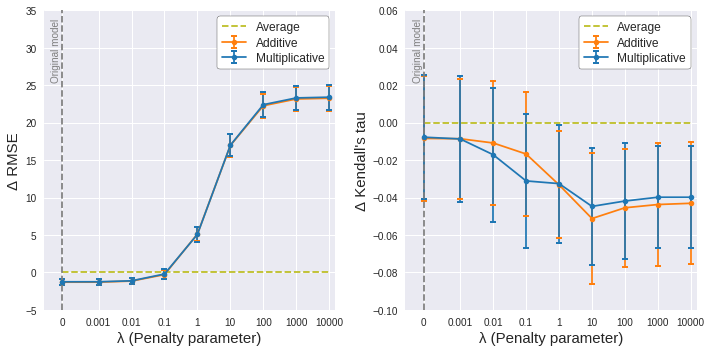

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Calculate alpha for 95% confidence interval for mean differences (n=10, 97.5% quantile=2.262 for 9 degree of freedom)
alpha = 2.262/sqrt(10)

# Set options for error bar and legends (wider spacing)
errorbar_opts = {'markeredgewidth': 2, 'capsize': 3}
custom_opts = legend_opts.copy()
custom_opts['labelspacing'] = 0.3

# Plot differences in RMSE from baseline for both models
ax1.errorbar(linear_lambda_df['lambda'], linear_lambda_df['rmse_diff_avg'], 
             yerr=alpha*linear_lambda_df['rmse_diff_std'],
           fmt='.-', color='tab:orange', label='Additive', **errorbar_opts)
ax1.errorbar(loglinear_lambda_df['lambda'], loglinear_lambda_df['rmse_diff_avg'], 
             yerr=alpha*loglinear_lambda_df['rmse_diff_std'],
           fmt='.-', color='tab:blue', label='Multiplicative', **errorbar_opts)

ax1.hlines(0, 0, 10000, linestyles='--', color='tab:olive', label='Average')
ax1.axvline(0, ls='--', color='tab:gray')
ax1.text(-0.0003, 34, s='Original model', verticalalignment='top', rotation=90, fontsize=10, color='tab:gray')
ax1.legend(loc='upper right', **custom_opts)

ax1.set_xlabel('λ (Penalty parameter)', fontsize=15)
ax1.set_xscale('symlog', linthreshx=0.001)
ax1.set_xlim(-0.0005, 15000)
ax1.set_xticklabels(lambda_values)

ax1.set_ylim(-5, 35)
ax1.set_ylabel('Δ RMSE', fontsize=15)

# Plot differences in Kendall's tau from baseline for both models
ax2.errorbar(linear_lambda_df['lambda'], linear_lambda_df['tau_diff_avg'], 
             yerr=alpha*linear_lambda_df['tau_diff_std'],
           fmt='.-', color='tab:orange', label='Additive', **errorbar_opts)
ax2.errorbar(loglinear_lambda_df['lambda'], loglinear_lambda_df['tau_diff_avg'], 
             yerr=alpha*loglinear_lambda_df['tau_diff_std'],
           fmt='.-', color='tab:blue', label='Multiplicative', **errorbar_opts)

ax2.hlines(0, 0, 10000, linestyles='--', color='tab:olive', label='Average')
ax2.text(-0.0003, 0.06-0.16*1/40, s='Original model', verticalalignment='top', rotation=90, fontsize=10, color='tab:gray')
ax2.axvline(0, ls='--', color='tab:gray')

ax2.legend(loc='upper right', **custom_opts)

ax2.set_xscale('symlog', linthreshx=0.001)
ax2.set_xlim(-0.0005, 15000)
ax2.set_xticklabels(lambda_values)
ax2.set_xlabel('λ (Penalty parameter)', fontsize=15)
ax2.set_ylim(-0.10, 0.06)
ax2.set_ylabel("Δ Kendall's tau", fontsize=15)

plt.tight_layout()
plt.show()

fig.savefig('viz/diff_rmse_tau_lambda.png')

### Closer look at un-penalized model

Compare un-penalized models to average score model for all 10 years

In [65]:
# Evaluate un-penalized models over all 10 years
linear = Linear(lambda_param=0)
linear_train_eval = linear.evaluate_over_years(train_years, season_train, world_train)
loglinear = LogLinear(lambda_param=0)
loglinear_train_eval = loglinear.evaluate_over_years(train_years, season_train, world_train)

In [66]:
# For each year, concatenant RMSE and Kendall's tau for all 3 models in one row
rmses_df = pd.concat([avg_train_eval['rmse'], linear_train_eval['rmse'], loglinear_train_eval['rmse']], axis=1,
                    keys=['avg', 'linear', 'loglinear'])
taus_df = pd.concat([avg_train_eval['tau'], linear_train_eval['tau'], loglinear_train_eval['tau']], axis=1,
                   keys=['avg', 'linear', 'loglinear'])

In [67]:
rmses_df

,avg,linear,loglinear
0,10.357050,8.555327,8.649373
1,9.749220,7.883763,7.932804
2,8.151442,7.578146,7.651527
3,8.557905,8.110917,8.188401
4,11.139947,9.798364,9.785044
5,9.424702,8.144647,8.321286
6,9.965307,9.047367,8.987620
7,10.563519,8.781486,8.813433
8,12.694622,11.053367,11.073864
9,10.271547,8.838700,8.881273


In [68]:
taus_df

,avg,linear,loglinear
0,0.647619,0.666667,0.666667
1,0.691700,0.620553,0.636364
2,0.630435,0.601449,0.601449
3,0.601449,0.586957,0.565217
4,0.714286,0.696970,0.714286
5,0.604743,0.541502,0.525692
6,0.604743,0.691700,0.683794
7,0.819048,0.809524,0.828571
8,0.695652,0.673913,0.673913
9,0.695652,0.731884,0.731884


Plot RMSE, and Kendall's tau for each year across 3 models

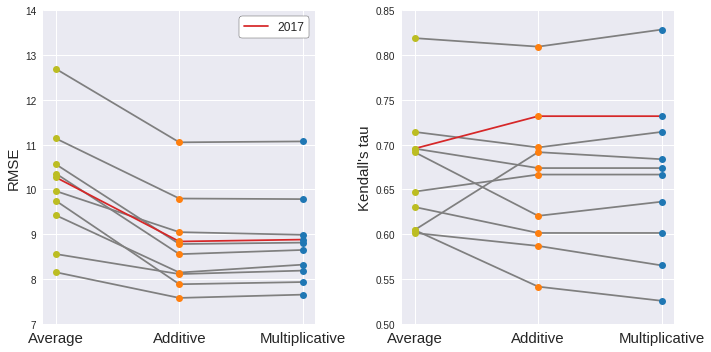

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot gray lines that connect RMSE data points for each year (highlight 2017 in red)
for i, row in rmses_df.iterrows():
    if i == 9:
        line_2017 = ax1.plot(range(3), row, color='tab:red')
    else:
        ax1.plot(range(3), row, color='tab:gray')
        
# Plot RMSE for all models
ax1.plot([0]*len(rmses_df), rmses_df['avg'], 'o', color='tab:olive')
ax1.plot([1]*len(rmses_df), rmses_df['linear'], 'o', color='tab:orange')
ax1.plot([2]*len(rmses_df), rmses_df['loglinear'], 'o', color='tab:blue')
        
ax1.legend(line_2017, ['2017'], loc='upper right', **legend_opts)

ax1.set_xticks(range(3))
ax1.set_xticklabels(['Average', 'Additive', 'Multiplicative'], fontsize=15)
ax1.set_ylabel('RMSE', fontsize=15)
ax1.set_ylim(7, 14)

# Plot gray lines that connect Kendall's tau data points for each year (highlight 2017 in red)
for i, row in taus_df.iterrows():
    if i == 9:
        line_2017 = ax2.plot(range(3), row, color='tab:red')
    else:
        ax2.plot(range(3), row, color='tab:gray')

# Plot Kendall's tau for all models
ax2.plot([0]*len(taus_df), taus_df['avg'], 'o', color='tab:olive')
ax2.plot([1]*len(taus_df), taus_df['linear'], 'o', color='tab:orange')
ax2.plot([2]*len(taus_df), taus_df['loglinear'], 'o', color='tab:blue')

ax2.set_xticks(range(3))
ax2.set_xticklabels(['Average', 'Additive', 'Multiplicative'], fontsize=15)
ax2.set_ylabel("Kendall's tau", fontsize=15)
ax2.set_ylim(0.5, 0.85)

plt.tight_layout()
plt.show()

fig.savefig('viz/diff_rmse_tau_male.png')

## Final report

Report differences in RMSE and Kendall's tau (mean and 95% confidence interval via t-distribution) for additive model

In [70]:
linear_rmse_diffs = linear_train_eval['rmse'] - avg_train_eval['rmse']
linear_tau_diffs = linear_train_eval['tau'] - avg_train_eval['tau']

In [71]:
[linear_rmse_diffs.mean(),
linear_rmse_diffs.mean() - alpha * linear_rmse_diffs.std(),
linear_rmse_diffs.mean() + alpha * linear_rmse_diffs.std()]

[-1.3083179087964896, -1.6731370023931826, -0.9434988151997965]

In [72]:
[linear_tau_diffs.mean(),
linear_tau_diffs.mean() - alpha * linear_tau_diffs.std(),
linear_tau_diffs.mean() + alpha * linear_tau_diffs.std()]

[-0.008420854507811016, -0.04171868667978176, 0.02487697766415973]

Report differences in RMSE and Kendall's tau (mean and 95% confidence interval via t-distribution) for multiplicative model

In [73]:
loglinear_rmse_diffs = loglinear_train_eval['rmse'] - avg_train_eval['rmse']
loglinear_tau_diffs = loglinear_train_eval['tau'] - avg_train_eval['tau']

In [74]:
[loglinear_rmse_diffs.mean(),
loglinear_rmse_diffs.mean() - alpha * loglinear_rmse_diffs.std(),
loglinear_rmse_diffs.mean() + alpha * loglinear_rmse_diffs.std()]

[-1.259063741118085, -1.627000695612883, -0.8911267866232869]

In [75]:
[loglinear_tau_diffs.mean(),
 loglinear_tau_diffs.mean() - alpha * loglinear_tau_diffs.std(),
 loglinear_tau_diffs.mean() + alpha * loglinear_tau_diffs.std()]

[-0.007748917748917739, -0.04091773475695804, 0.025419899259122563]

### Do the same for female skaters

In [76]:
fseason_train, fworld_train, fseason_test, fworld_test = train_test_split(female_scores, train_years, test_years)
fseason_train.shape, fworld_train.shape, fseason_test.shape, fworld_test.shape

((1220, 4), (239, 4), (507, 4), (95, 4))

In [77]:
favg = AverageScore()
favg_train_eval = favg.evaluate_over_years(train_years, fseason_train, fworld_train)
favg_train_eval

,year,rmse,tau,conc,pairs
0,2005,7.565816,0.590476,167,210
1,2006,7.742614,0.593074,184,231
2,2007,7.169302,0.710145,236,276
3,2009,5.972928,0.683794,213,253
4,2010,9.310778,0.509881,191,253
5,2012,6.737205,0.523810,176,231
6,2013,5.924964,0.588933,201,253
7,2014,8.373916,0.722944,199,231
8,2016,6.556561,0.731884,239,276
9,2017,6.609788,0.579710,218,276


In [78]:
flinear = Linear(lambda_param=0)
flinear_train_eval = flinear.evaluate_over_years(train_years, fseason_train, fworld_train)
flinear_train_eval

,year,rmse,tau,conc,pairs
0,2005,6.376851,0.561905,164,210
1,2006,6.582065,0.610390,186,231
2,2007,6.428264,0.739130,240,276
3,2009,5.342399,0.683794,213,253
4,2010,6.983639,0.486166,188,253
5,2012,5.670575,0.471861,170,231
6,2013,5.036148,0.596838,202,253
7,2014,6.274096,0.722944,199,231
8,2016,6.293459,0.731884,239,276
9,2017,6.129382,0.623188,224,276


In [79]:
floglinear = LogLinear(lambda_param=0)
floglinear_train_eval = floglinear.evaluate_over_years(train_years, fseason_train, fworld_train)
floglinear_train_eval

,year,rmse,tau,conc,pairs
0,2005,6.386825,0.561905,164,210
1,2006,6.613729,0.610390,186,231
2,2007,6.467467,0.739130,240,276
3,2009,5.432953,0.675889,212,253
4,2010,6.845203,0.494071,189,253
5,2012,5.659339,0.480519,171,231
6,2013,5.004460,0.604743,203,253
7,2014,6.328152,0.714286,198,231
8,2016,6.313307,0.739130,240,276
9,2017,6.172280,0.623188,224,276


In [80]:
# For each year, concatenant RMSE and Kendall's tau for all 3 models in one row
frmses_df = pd.concat([favg_train_eval['rmse'], flinear_train_eval['rmse'], floglinear_train_eval['rmse']], axis=1,
                    keys=['avg', 'linear', 'loglinear'])
ftaus_df = pd.concat([favg_train_eval['tau'], flinear_train_eval['tau'], floglinear_train_eval['tau']], axis=1,
                   keys=['avg', 'linear', 'loglinear'])

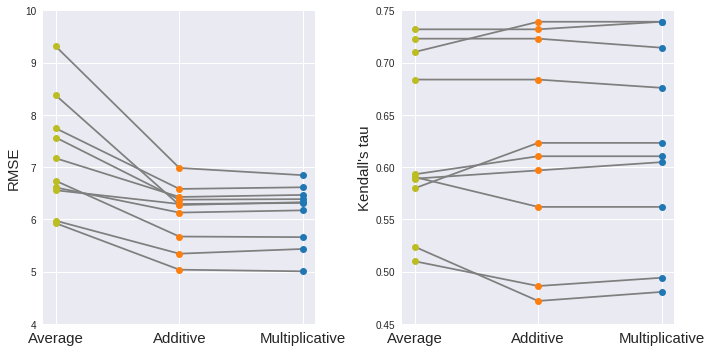

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot gray lines that connect RMSE data points for each year
for i, row in frmses_df.iterrows():
    ax1.plot(range(3), row, color='tab:gray')
    
# Plot RMSE for all models
ax1.plot([0]*len(frmses_df), frmses_df['avg'], 'o', color='tab:olive')
ax1.plot([1]*len(frmses_df), frmses_df['linear'], 'o', color='tab:orange')
ax1.plot([2]*len(frmses_df), frmses_df['loglinear'], 'o', color='tab:blue')

ax1.set_xticks(range(3))
ax1.set_xticklabels(['Average', 'Additive', 'Multiplicative'], fontsize=15)
ax1.set_ylabel('RMSE', fontsize=15)
ax1.set_ylim(4, 10)

# Plot gray lines that connect Kendall's tau data points for each year
for i, row in ftaus_df.iterrows():
    ax2.plot(range(3), row, color='tab:gray') 
    
# Plot Kendall's tau for all models
ax2.plot([0]*len(ftaus_df), ftaus_df['avg'], 'o', color='tab:olive')
ax2.plot([1]*len(ftaus_df), ftaus_df['linear'], 'o', color='tab:orange')
ax2.plot([2]*len(ftaus_df), ftaus_df['loglinear'], 'o', color='tab:blue')

ax2.set_xticks(range(3))
ax2.set_xticklabels(['Average', 'Additive', 'Multiplicative'], fontsize=15)
ax2.set_ylabel("Kendall's tau", fontsize=15)
ax2.set_ylim(0.45, 0.75)

plt.tight_layout()
plt.show()

fig.savefig('viz/diff_rmse_tau_female.png')

Report differences in RMSE and Kendall's tau (mean and 95% confidence interval via t-distribution) for additive model

In [82]:
flinear_rmse_diffs = flinear_train_eval['rmse'] - favg_train_eval['rmse']
flinear_tau_diffs = flinear_train_eval['tau'] - favg_train_eval['tau']

In [83]:
[flinear_rmse_diffs.mean(),
flinear_rmse_diffs.mean() - alpha * flinear_rmse_diffs.std(),
flinear_rmse_diffs.mean() + alpha * flinear_rmse_diffs.std()]

[-1.0846994716567866, -1.5612140068433635, -0.6081849364702097]

In [84]:
[flinear_tau_diffs.mean(),
flinear_tau_diffs.mean() - alpha * flinear_tau_diffs.std(),
flinear_tau_diffs.mean() + alpha * flinear_tau_diffs.std()]

[-0.0006549971767363328, -0.020838989621060844, 0.01952899526758818]

Report differences in RMSE and Kendall's tau (mean and 95% confidence interval via t-distribution) for multiplicative model

In [85]:
floglinear_rmse_diffs = floglinear_train_eval['rmse'] - favg_train_eval['rmse']
floglinear_tau_diffs = floglinear_train_eval['tau'] - favg_train_eval['tau']

In [86]:
[floglinear_rmse_diffs.mean(),
 floglinear_rmse_diffs.mean() - alpha * floglinear_rmse_diffs.std(),
 floglinear_rmse_diffs.mean() + alpha * floglinear_rmse_diffs.std()]

[-1.074015944566933, -1.5762823070328977, -0.5717495821009684]

In [87]:
[floglinear_tau_diffs.mean(),
 floglinear_tau_diffs.mean() - alpha * floglinear_tau_diffs.std(),
 floglinear_tau_diffs.mean() + alpha * floglinear_tau_diffs.std()]

[0.0008601543384151644, -0.018219488982730885, 0.019939797659561217]